In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)

1.3.0


## Prediction / regression pipeline

Here we try to predict y(t) based on x(s <= t). y(t) may be x(t+1).

In [2]:
batch_size = 128
d_x = 1
n_classes = 3

## Making room for the sequences

Let's create placeholders for our input data x and output data y.

In [3]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None, d_x), dtype=tf.float32)
seq_class_ph = tf.placeholder(shape=(batch_size, 1), dtype=tf.int32)

## Preparing the network's modules

Let's define a convolution layer

In [4]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1):
    conv_kernel = tf.get_variable(
        name="kernel",
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding="SAME",
        strides=None,
        dilation_rate=[dilation]
    )
    return conv_output

## A simple auto-regressive model

Let's build a AR(p) model with tensorflow

In [5]:
p = 2

with tf.variable_scope("AR_p_model"):
    y_predicted = convolution_layer(x_seq_ph, d_x, n_classes, width=p)
    logit = tf.reduce_mean(y_predicted, axis=1)

In [6]:
seq_label = tf.one_hot(seq_class_ph, n_classes)

loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=seq_label, logits=logit))

In [7]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

## Pathological example with white noise

In [8]:
def generate_samples(batch_size, sequence_length, n_dims):
    trend = np.random.normal(0.0, 1.0, (batch_size, 1, 1))
    trend_sign = np.sign(trend) + 1
    seq = np.cumsum(trend 
                    + np.random.normal(0.0, 1.0, (batch_size, 
                                                  sequence_length, 
                                                  n_dims)),
                    axis=1)
    return seq, trend_sign[:,:,0]

## We ask to predict the next value of a white noise process, this should not work with a causal convolution and yet it does here

In [9]:
n_steps = int(1e4)
sequence_length = 128

session = tf.Session()

session.run(tf.global_variables_initializer())

for step in xrange(n_steps):
    x_seq, trend_sign = generate_samples(batch_size, sequence_length, d_x)
    loss_eval, _ = session.run((loss, optimizer), 
                               feed_dict={x_seq_ph: x_seq, 
                                          seq_class_ph: trend_sign})

    if not (step % 100): print loss_eval

260.228
23.8822
22.9022
23.6607
12.1916
30.8174
7.97247
14.0236
19.1
15.3957
8.21467
8.0568
14.509
15.1413
14.448
18.4095
10.4815
11.8744
15.0485
11.2783
21.1895
11.8849
14.9512
14.1497
13.6699
21.1124
12.9996
21.4862
13.8835
16.9001
14.2105
17.6556
18.4177
12.0495
11.8968
17.689
26.986
8.83844
15.203
7.40141
21.716
11.4749
13.71
16.3281
24.9347
12.6213
13.8399
6.95474
14.8747
11.9714
17.729
8.60904
22.319
8.45846
13.4638
6.08965
13.8939
20.6391
22.1738
12.2988
12.8081
12.9379
21.3831
12.3702
18.7493
6.34362
18.795
14.6058
20.0749
7.36151
7.55481
9.27071
15.7582
10.9423
16.7948
18.505
21.3765
18.171
13.9922
23.9694
17.9703
11.1302
12.7466
21.15
13.5459
22.2455
16.7953
17.9524
15.0504
14.7452
24.0885
15.5709
25.9272
19.6909
21.6803
21.4855
9.66251
19.7735
20.1555
7.0101


In [10]:
variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="AR_p_model")

print([v.name for v in variables])
kernel = [v for v in variables if "kernel" in v.name.split('/')[-1]][0]

kernel_eval = session.run(kernel)

[u'AR_p_model/kernel:0', u'AR_p_model/kernel/RMSProp:0', u'AR_p_model/kernel/RMSProp_1:0']


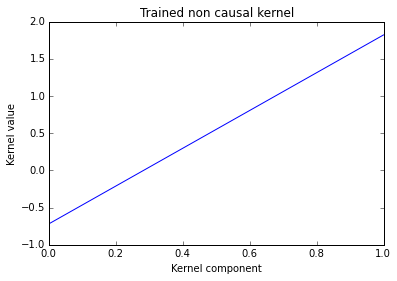

In [11]:
plt.plot(kernel_eval[:,0,0])
plt.title("Trained non causal kernel")
plt.ylabel("Kernel value")
plt.xlabel("Kernel component")
plt.show()

[ 0.]


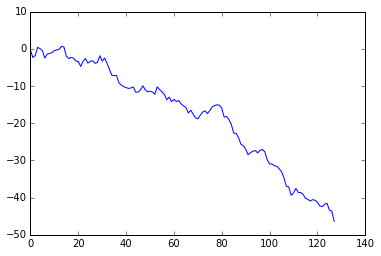

In [12]:
plt.plot(x_seq[0,:,:])
print(trend_sign[0])

In [13]:
print(trend_sign)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]]
